In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
%matplotlib inline
sns.set(style="ticks")

from scipy.stats import zscore
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

In [2]:
data = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx','Data')
data.columns = ["ID","Age","Experience","Income","ZIPCode","Family","CCAvg","Education","Mortgage","PersonalLoan","SecuritiesAccount","CDAccount","Online","CreditCard"]

In [3]:
data.head()


,ID,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [4]:
data.columns


Index(['ID', 'Age', 'Experience', 'Income', 'ZIPCode', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'PersonalLoan', 'SecuritiesAccount',
       'CDAccount', 'Online', 'CreditCard'],
      dtype='object')

In [5]:
data.shape


(5000, 14)

In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                   5000 non-null int64
Age                  5000 non-null int64
Experience           5000 non-null int64
Income               5000 non-null int64
ZIPCode              5000 non-null int64
Family               5000 non-null int64
CCAvg                5000 non-null float64
Education            5000 non-null int64
Mortgage             5000 non-null int64
PersonalLoan         5000 non-null int64
SecuritiesAccount    5000 non-null int64
CDAccount            5000 non-null int64
Online               5000 non-null int64
CreditCard           5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [7]:
# No columns have null data in the file
data.apply(lambda x : sum(x.isnull()))

ID                   0
Age                  0
Experience           0
Income               0
ZIPCode              0
Family               0
CCAvg                0
Education            0
Mortgage             0
PersonalLoan         0
SecuritiesAccount    0
CDAccount            0
Online               0
CreditCard           0
dtype: int64

In [8]:
# Eye balling the data
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


In [9]:
#finding unique data
data.apply(lambda x: len(x.unique()))

ID                   5000
Age                    45
Experience             47
Income                162
ZIPCode               467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
PersonalLoan            2
SecuritiesAccount       2
CDAccount               2
Online                  2
CreditCard              2
dtype: int64

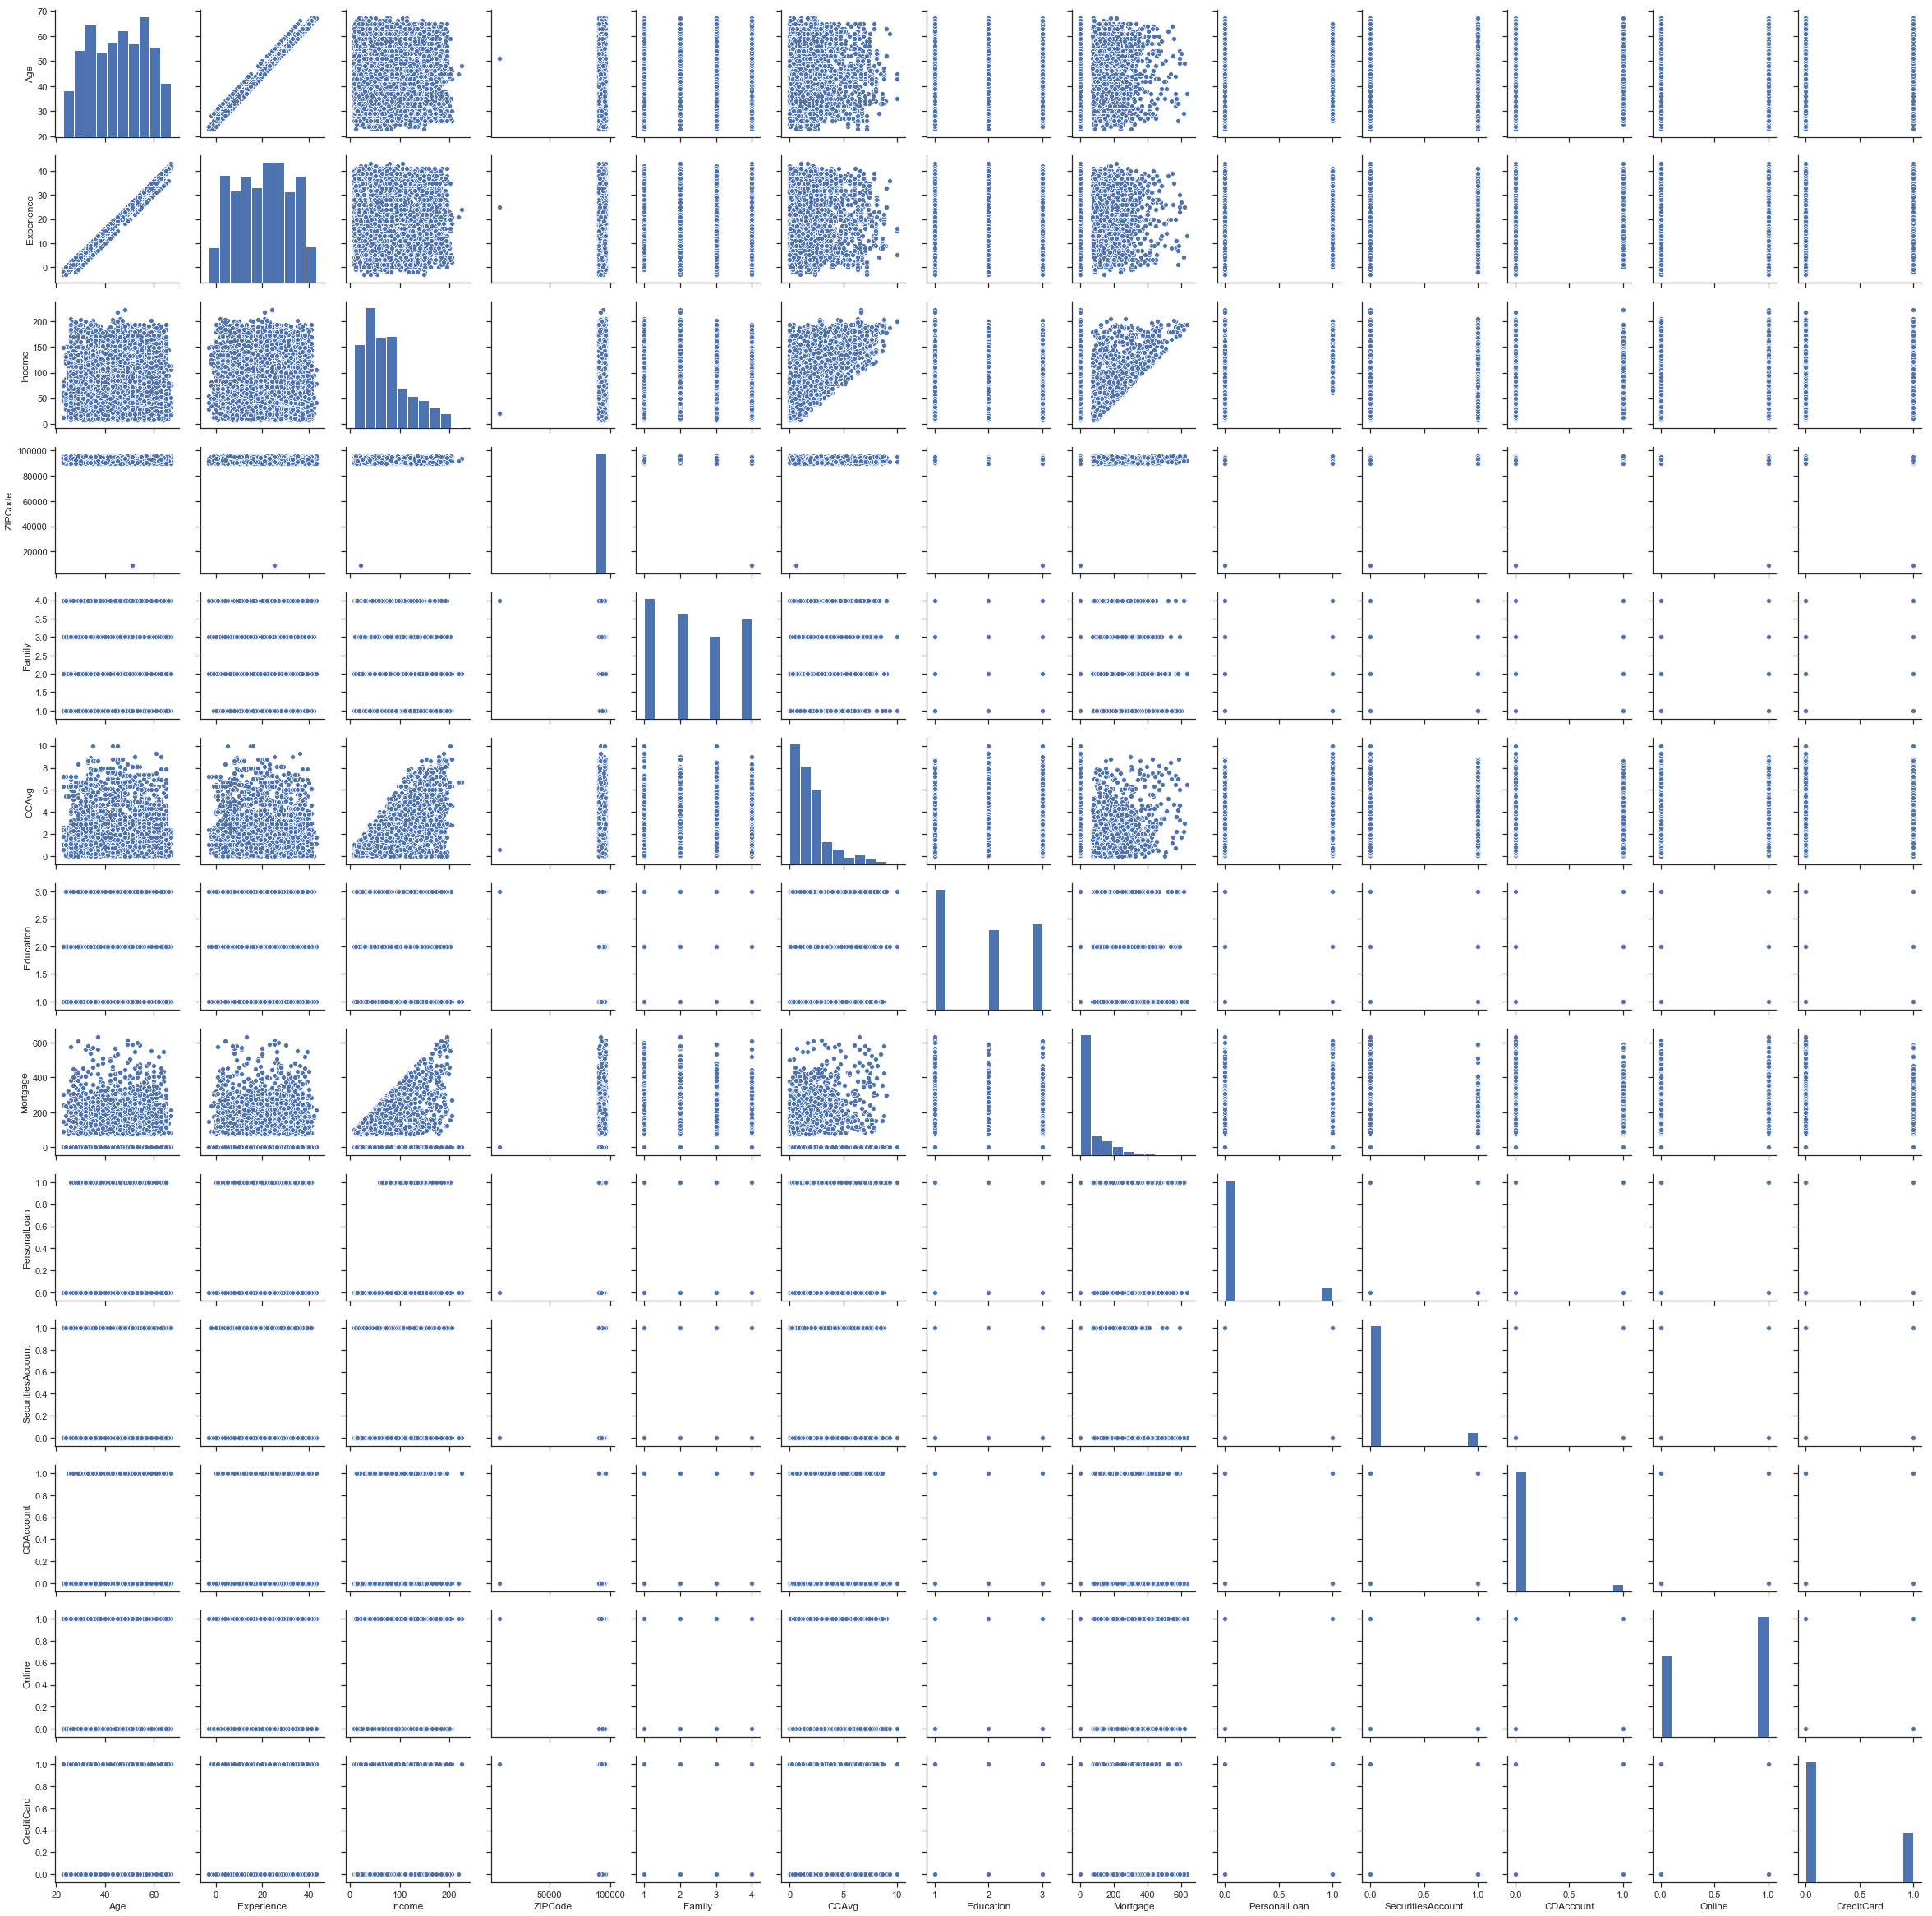

In [10]:
sns.pairplot(data.iloc[:,1:])


In [11]:
# there are 52 records with negative experience. Before proceeding any further we need to clean the same
data[data['Experience'] < 0]['Experience'].count()

52

In [12]:
#clean the negative variable
dfExp = data.loc[data['Experience'] >0]
negExp = data.Experience < 0
column_name = 'Experience'
mylist = data.loc[negExp]['ID'].tolist() # getting the customer ID who has negative experience

In [13]:
# there are 52 records with negative experience
negExp.value_counts()

False    4948
True       52
Name: Experience, dtype: int64

In [14]:
for id in mylist:
    age = data.loc[np.where(data['ID']==id)]["Age"].tolist()[0]
    education = data.loc[np.where(data['ID']==id)]["Education"].tolist()[0]
    df_filtered = dfExp[(dfExp.Age == age) & (dfExp.Education == education)]
    exp = df_filtered['Experience'].median()
    data.loc[data.loc[np.where(data['ID']==id)].index, 'Experience'] = exp

In [15]:
data[data['Experience'] < 0]['Experience'].count()


0

In [16]:
data.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,4971.0,20.243211,11.359189,0.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIPCode,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


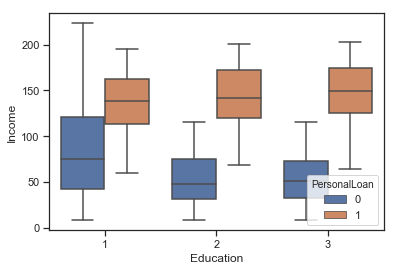

In [17]:
sns.boxplot(x='Education',y='Income',hue='PersonalLoan',data=data)


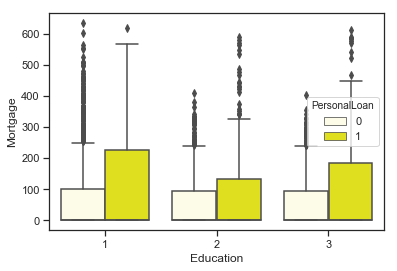

In [18]:
sns.boxplot(x="Education", y='Mortgage', hue="PersonalLoan", data=data,color='yellow')


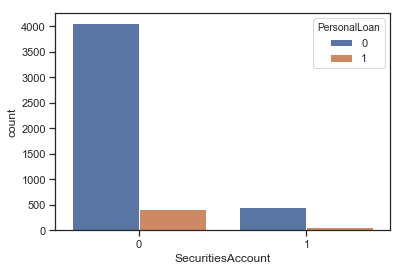

In [19]:
sns.countplot(x="SecuritiesAccount", data=data,hue="PersonalLoan")


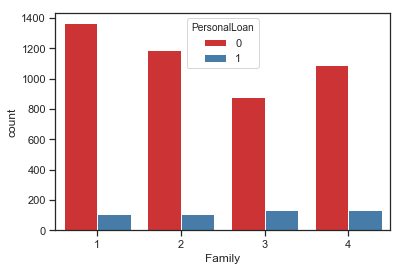

In [20]:
sns.countplot(x='Family',data=data,hue='PersonalLoan',palette='Set1')


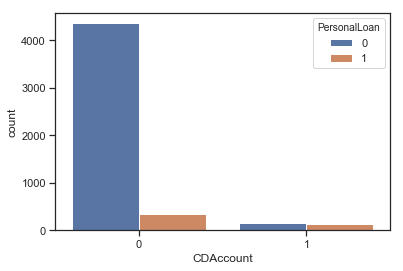

In [21]:
sns.countplot(x='CDAccount',data=data,hue='PersonalLoan')


G:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


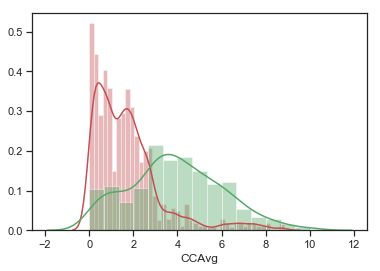

In [22]:

sns.distplot( data[data.PersonalLoan == 0]['CCAvg'], color = 'r')
sns.distplot( data[data.PersonalLoan == 1]['CCAvg'], color = 'g')

In [23]:
print('Credit card spending of Non-Loan customers: ',data[data.PersonalLoan == 0]['CCAvg'].median()*1000)
print('Credit card spending of Loan customers    : ', data[data.PersonalLoan == 1]['CCAvg'].median()*1000)

Credit card spending of Non-Loan customers:  1400.0
Credit card spending of Loan customers    :  3800.0


Text(0, 0.5, 'Age')

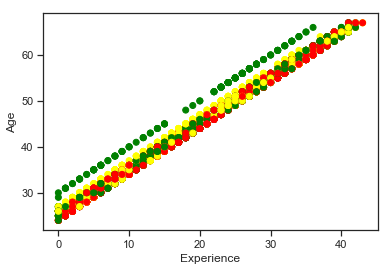

In [24]:
fig, ax = plot.subplots()
colors = {1:'red',2:'yellow',3:'green'}
ax.scatter(data['Experience'],data['Age'],c=data['Education'].apply(lambda x:colors[x]))
plot.xlabel('Experience')
plot.ylabel('Age')

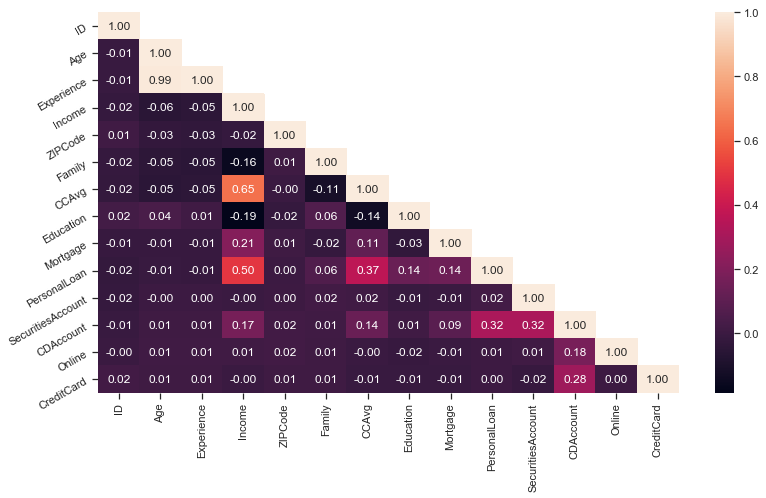

In [25]:
# Correlation with heat map
import matplotlib.pyplot as plt
import seaborn as sns
corr = data.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
# create a mask so we only see the correlation values once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

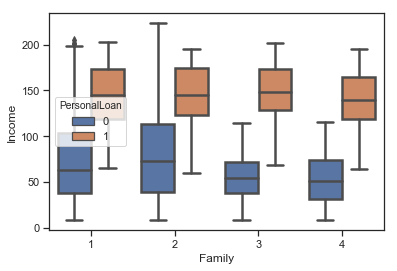

In [26]:
sns.boxplot(x=data.Family,y=data.Income,hue=data.PersonalLoan)
# Looking at the below plot, families with income less than 100K are less likely to take loan,than families with 
# high income

In [27]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data.drop(['ID','Experience'], axis=1), test_size=0.3 , random_state=100)

In [28]:
train_labels = train_set.pop('PersonalLoan')
test_labels = test_set.pop('PersonalLoan')

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dt_model=DecisionTreeClassifier(criterion = 'entropy',max_depth=3)
dt_model.fit(train_set, train_labels)


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [30]:
dt_model.score(test_set , test_labels)


0.9773333333333334

In [31]:
y_predict = dt_model.predict(test_set)
y_predict[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [32]:
test_set.head(5)


,Age,Income,ZIPCode,Family,CCAvg,Education,Mortgage,SecuritiesAccount,CDAccount,Online,CreditCard
789,29,31,92126,4,0.3,2,0,0,0,1,0
2507,59,60,90048,4,2.1,1,234,0,0,1,1
2376,58,23,91768,3,0.2,1,0,0,0,0,0
1378,54,34,93305,4,0.1,3,0,0,0,1,0
598,56,11,92374,2,0.2,3,90,0,0,0,0


In [33]:
naive_model = GaussianNB()
naive_model.fit(train_set, train_labels)

prediction = naive_model.predict(test_set)
naive_model.score(test_set,test_labels)

0.8866666666666667

In [34]:
randomforest_model = RandomForestClassifier(max_depth=2, random_state=0)
randomforest_model.fit(train_set, train_labels)

G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

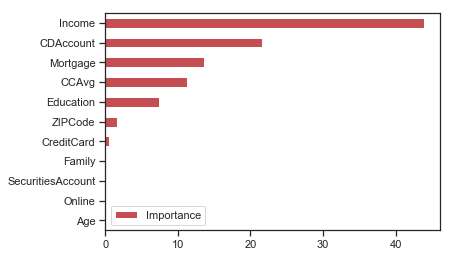

In [35]:
Importance = pd.DataFrame({'Importance':randomforest_model.feature_importances_*100}, index=train_set.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )

In [36]:
predicted_random=randomforest_model.predict(test_set)
randomforest_model.score(test_set,test_labels)

0.8993333333333333

In [37]:
train_set_indep = data.drop(['Experience' ,'ID'] , axis = 1).drop(labels= "PersonalLoan" , axis = 1)
train_set_dep = data["PersonalLoan"]
X = np.array(train_set_indep)
Y = np.array(train_set_dep)
X_Train = X[ :3500, :]
X_Test = X[3501: , :]
Y_Train = Y[:3500, ]
Y_Test = Y[3501:, ]

In [38]:
knn = KNeighborsClassifier(n_neighbors= 21 , weights = 'uniform', metric='euclidean')
knn.fit(X_Train, Y_Train)    
predicted = knn.predict(X_Test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(Y_Test, predicted)
print(acc)

0.9106070713809206


In [39]:
X=data.drop(['PersonalLoan','Experience','ID'],axis=1)
y=data.pop('PersonalLoan')

KNN: 0.898600 (0.008902)
CART: 0.981400 (0.004005)
NB: 0.885600 (0.010385)


G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 

RF: 0.983200 (0.004400)


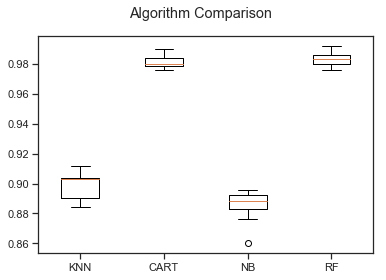

In [40]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=12345)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# https://www.kaggle.com/itsmesunil/campaign-for-selling-personal-loans